In [2]:
import os
import rasterio
from pathlib import Path
import geopandas as geopd
import pandas as pd
import numpy as np
from rasterio import features as r_feat
from rasterio import plot as r_plot
import shutil
import seaborn as sns
import matplotlib.pyplot as plt


os.chdir('/home/me/workspace/det_remota/trabalho_final')

In [3]:
AQUACULTURE_POLY_PATH = Path('data/qgis_outputs/dzetsaka_models/predicted_rasters/aquaculture_polygons')

def read_aquaculture_poly(path:Path):
    year = int(str(path).split('/')[-1].split('_')[-1].split('.')[0])
    aqua_gdf = geopd.read_file(path)
    aqua_gdf = aqua_gdf[['geometry']]
    aqua_gdf['Ano'] = year
    aqua_gdf['Area (ha)'] = aqua_gdf.geometry.area/10_000
    return aqua_gdf

aquaculture_gdf = pd.concat([
    read_aquaculture_poly(x) 
    for x in AQUACULTURE_POLY_PATH.glob('*.gpkg')
], ignore_index=True)
# aquaculture_gdf.drop(
#     aquaculture_gdf.index[aquaculture_gdf['Area (ha)'] > 500],
#     inplace=True
# )

print(aquaculture_gdf.describe().to_markdown())

|       |        Ano |   Area (ha) |
|:------|-----------:|------------:|
| count | 10087      | 10087       |
| mean  |  2020.56   |     5.33145 |
| std   |     2.3028 |     9.31542 |
| min   |  2017      |     1.04899 |
| 25%   |  2019      |     1.53968 |
| 50%   |  2021      |     2.36224 |
| 75%   |  2023      |     5.0076  |
| max   |  2024      |   183.114   |


In [4]:
TANQUES_STATS_COLUMNS = {
    'count': 'Contagem',
    'sum': 'Área Total (mil ha)',
    'mean': 'Área Média (ha)',
    'std': 'Desvio Padrão (ha)',
    'max': 'Máximo (ha)',
}

tanques_stats_df = aquaculture_gdf.groupby('Ano')['Area (ha)']\
    .aggregate(list(TANQUES_STATS_COLUMNS.keys()))

tanques_stats_df.rename(columns=TANQUES_STATS_COLUMNS, inplace=True)
tanques_stats_df[TANQUES_STATS_COLUMNS['sum']] /= 1_000
print(tanques_stats_df.iloc[:, [0, -3, -2, -1]].round(3).to_markdown())

|   Ano |   Contagem |   Área Média (ha) |   Desvio Padrão (ha) |   Máximo (ha) |
|------:|-----------:|------------------:|---------------------:|--------------:|
|  2017 |       1240 |             4.776 |                7.256 |       100.814 |
|  2018 |       1203 |             5.181 |                8.367 |       104.963 |
|  2019 |       1246 |             5.344 |                8.953 |       100.487 |
|  2020 |       1285 |             5.347 |                9.211 |       134.836 |
|  2021 |       1179 |             5.41  |                8.813 |        84.77  |
|  2022 |       1268 |             5.368 |                9.446 |       143.906 |
|  2023 |       1353 |             5.492 |               10.351 |       164.004 |
|  2024 |       1313 |             5.696 |               11.285 |       183.114 |


Text(0, 0.5, '')

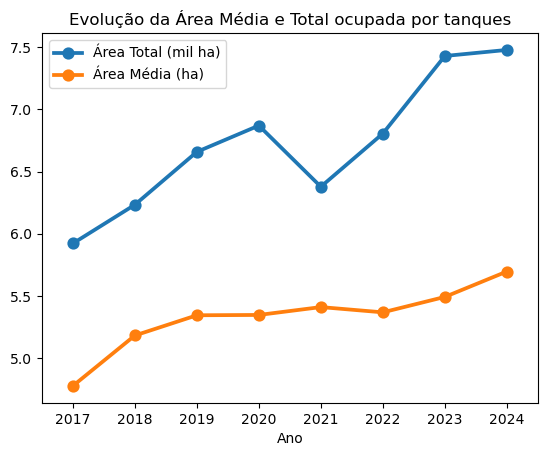

In [5]:
ax = sns.pointplot(tanques_stats_df, x='Ano', 
                   y='Área Total (mil ha)', label='Área Total (mil ha)')

sns.pointplot(tanques_stats_df, x='Ano', y='Área Média (ha)',
              label = 'Área Média (ha)', ax=ax)

plt.title('Evolução da Área Média e Total ocupada por tanques')
plt.ylabel(None)

In [6]:
RIPARIAN_ZONAL_STATS_PATH = Path('data/qgis_outputs/dzetsaka_models/predicted_rasters/riparian_zonal_stats')

SOURCE_GDFS_PATHS = RIPARIAN_ZONAL_STATS_PATH.glob('*.gpkg') 
SOURCE_GDFS = []
for src_path in SOURCE_GDFS_PATHS:
    year = str(src_path).split('/')[-1].split('_')[-1].replace('.gpkg', '')
    
    gdf = geopd.read_file(src_path)[['mask_count', 'mask_sum', 'ndvi_sum']]
    gdf['% Cobertura Florestal'] =  gdf.mask_sum/gdf.mask_count
    gdf['NDVI Médio'] =  gdf.ndvi_sum/gdf.mask_sum
    gdf['Ano'] = int(year)
    gdf = gdf[['Ano', '% Cobertura Florestal','NDVI Médio']]
    gdf['% Cobertura Florestal'] *= 100
    gdf.fillna(0, inplace=True)
    SOURCE_GDFS.append(gdf)

zonal_stats_gdf = pd.concat(SOURCE_GDFS, ignore_index=True)
zonal_stats_gdf.groupby('Ano').describe()

% Cobertura Florestal                                                 \
                     count       mean        std  min       25%       50%   
Ano                                                                         
2017                 904.0  14.418667  20.695060  0.0  0.992967  6.194241   
2018                 886.0  14.587720  20.350542  0.0  1.401998  7.081516   
2019                 956.0  14.533449  22.569031  0.0  0.802034  5.411043   
2020                 958.0  13.351037  20.417394  0.0  0.831917  5.544338   
2021                 886.0   9.075403  15.081056  0.0  0.354767  2.839605   
2022                 960.0  11.625869  17.478476  0.0  0.626406  5.097324   
2023                1068.0  12.765556  18.423440  0.0  0.545258  5.665466   
2024                1023.0  12.510619  18.763465  0.0  0.579374  4.934542   

                       NDVI Médio                                          \
            75%    max      count        mean        std  min         25%   
Ano                                                                         
2017  19.145330  100.0      904.0  142.761614  59.736416  0.0  156.542130   
2018  18.856285  100.0      886.0  143.831571  59.920178  0.0  156.682692   
2019  17.454046  100.0      956.0  134.982580  64.601665  0.0  154.407961   
2020  15.961114  100.0      958.0  137.890513  63.433129  0.0  155.380000   
2021  10.974942  100.0      886.0  128.460760  66.100399  0.0  153.500000   
2022  14.805391  100.0      960.0  137.680081  64.758975  0.0  155.083333   
2023  17.499574  100.0     1068.0  133.789645  65.855084  0.0  154.136364   
2024  15.904445  100.0     1023.0  135.866764  65.617652  0.0  155.048666   

                                          
             50%         75%         max  
Ano                                       
2017  162.078835  170.606451  239.000000  
2018  162.984043  171.129954  238.137924  
2019  160.732143  167.868706  242.448986  
2020  161.908429  169.680345  242.666667  
2021  159.431438  163.796200  210.421053  
2022  162.032319  170.415051  222.052632  
2023  161.111028  168.221198  215.000000  
2024  162.507092  169.181814  228.413043

Text(0.5, 1.0, 'NDVI Mediano da Cobertura Florestal')

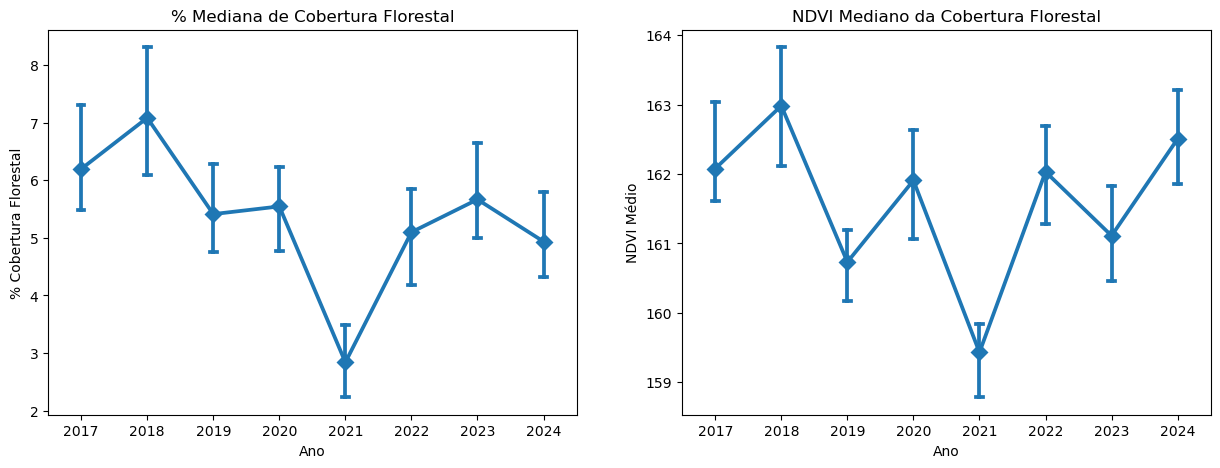

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(15,5))

sns.pointplot(
    zonal_stats_gdf, x='Ano', y='% Cobertura Florestal', 
    estimator="median",
    capsize=0.1,
    markers="D",
    ax=axes[0]
)
axes[0].set_title('% Mediana de Cobertura Florestal', fontsize=12, x=0.5)

sns.pointplot(
    zonal_stats_gdf, x='Ano', y='NDVI Médio', 
    estimator="median",
    capsize=0.1,
    markers="D",
    ax=axes[1]
)
axes[1].set_title('NDVI Mediano da Cobertura Florestal', fontsize=12, x=0.5)